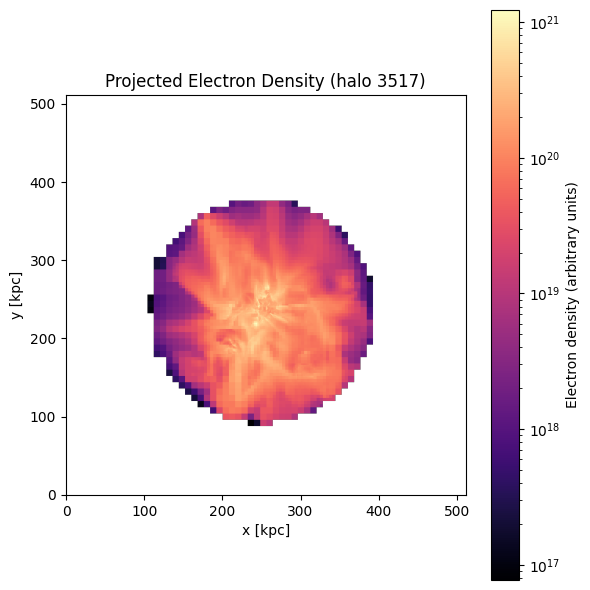

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.io import FortranFile

# ---------- Helper: read MEGATRON gas cutout ----------
def read_megatron_cutout(ff):
    header = [
        "redshift","dx","x","y","z","vx","vy","vz","nH","T","P",
        "nFe","nO","nN","nMg","nNe","nSi","nCa","nC","nS","nCO",
        "O_I","O_II","O_III","O_IV","O_V","O_VI","O_VII","O_VIII",
        "N_I","N_II","N_III","N_IV","N_V","N_VI","N_VII",
        "C_I","C_II","C_III","C_IV","C_V","C_VI",
        "Mg_I","Mg_II","Mg_III","Mg_IV","Mg_V","Mg_VI","Mg_VII","Mg_VIII","Mg_IX","Mg_X",
        "Si_I","Si_II","Si_III","Si_IV","Si_V","Si_VI","Si_VII","Si_VIII","Si_IX","Si_X","Si_XI",
        "S_I","S_II","S_III","S_IV","S_V","S_VI","S_VII","S_VIII","S_IX","S_X","S_XI",
        "Fe_I","Fe_II","Fe_III","Fe_IV","Fe_V","Fe_VI","Fe_VII","Fe_VIII","Fe_IX","Fe_X","Fe_XI",
        "Ne_I","Ne_II","Ne_III","Ne_IV","Ne_V","Ne_VI","Ne_VII","Ne_VIII","Ne_IX","Ne_X",
        "H_I","H_II","He_II","He_III",
        "Habing","Lyman_Werner","HI_Ionising","H2_Ionising","HeI_Ionising","HeII_ionising"
    ]
    ncols = len(header)
    all_data = []
    for _ in range(ncols):
        all_data.append(ff.read_reals("float64"))
    arr = np.column_stack(all_data)
    df = {col: arr[:, i] for i, col in enumerate(header)}

    # electron density
    ne = (10.**df["nH"]) * df["H_II"]
    ne += ((0.24 * (10.**df["nH"]) / 0.76) / 4.0) * (df["He_II"] + 2.0 * df["He_III"])
    df["ne"] = ne

    # AMR level (approx)
    dx_arr = 10.**df["dx"]
    min_dx = dx_arr.min()
    levels = np.rint(20.0 - np.log2(dx_arr / min_dx)).astype(int)
    df["level"] = levels

    return df

# ---------- Physical constants ----------
k_B = 1.380649e-16      # erg/K
E_LYA = 1.634e-11       # erg (Lyα photon energy ~10.2 eV)
LAMBDA0 = 1e-23         # erg cm^3 s^-1 (normalisation)

# ---------- Main processing ----------
def main():
    # paths
    bin_path = os.path.expanduser("~/Documents/GitHub/hathor/dataset_examples/halo_3517_gas.bin")
    out_png = "./figs/output_plot.png"
    os.makedirs(os.path.dirname(out_png), exist_ok=True)

    # load data
    with FortranFile(bin_path, 'r') as ff:
        df = read_megatron_cutout(ff)

    # extract needed arrays
    pos = np.vstack((df["x"], df["y"], df["z"])).T    # assume Mpc
    pos_kpc = pos * 1000.0                           # Mpc -> kpc

    ne = df["ne"]                                    # cm^-3
    nH = 10.**df["nH"]                               # cm^-3
    T = 10.**df["T"]                                 # K
    dx_cm = 10.**df["dx"]                            # cm (cell size)

    # cooling function (power‑law)
    Lambda = LAMBDA0 * (T / 1e7)**-0.7               # erg cm^3 s^-1

    # emissivity per volume
    eps = ne * nH * Lambda                           # erg cm^-3 s^-1

    # weight for projection (surface brightness contribution)
    weight = eps * dx_cm                              # erg cm^-2 s^-1

    # image parameters
    npix = 512
    boxsize_mpc = 20.0
    boxsize_kpc = boxsize_mpc * 1000.0
    pixel_kpc = boxsize_kpc / npix

    # centre on halo (mean position)
    centre = pos_kpc.mean(axis=0)
    pos_shift = pos_kpc - centre + boxsize_kpc/2.0

    ix = np.floor(pos_shift[:,0] / pixel_kpc).astype(int)
    iy = np.floor(pos_shift[:,1] / pixel_kpc).astype(int)

    # mask inside image bounds
    mask = (ix >= 0) & (ix < npix) & (iy >= 0) & (iy < npix)
    ix = ix[mask]
    iy = iy[mask]
    w = weight[mask]

    # rasterise
    image = np.zeros((npix, npix), dtype=np.float64)
    np.add.at(image, (ix, iy), w)

    # redshift dimming (z=0.5)
    z = 0.5
    image *= (1.0 + z)**4

    # plot
    plt.figure(figsize=(6,6))
    plt.imshow(image.T, origin='lower', cmap='magma', norm=LogNorm())
    cbar = plt.colorbar(label=r'Surface brightness (erg cm$^{-2}$ s$^{-1}$ pixel$^{-1}$)')
    plt.xlabel('x [kpc]')
    plt.ylabel('y [kpc]')
    plt.title('Projected X‑ray / Lyα surface brightness (halo 3517, z=0.5)')
    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.close()

if __name__ == "__main__":
    main()